## Initialization

In [126]:
import os, sys
import torch
import transformers
from torch.utils.data import DataLoader, SequentialSampler
import argparse
import numpy as np 
import matplotlib.pyplot as plt
from tqdm import tqdm
import pickle
from rouge_score import rouge_scorer

In [127]:
import sys
sys.path.append("/home/divy/FiD")

In [128]:
import src
from src.data import load_data
from src.evaluation import ems
import src.model

## Load data

Try out NQ with NQ pretrained checkpoint

In [134]:
nq_path =  "/mnt/disks/external_mounted_disk/datasets/NQ/NQ/dev.json"
compose_path = "/mnt/disks/external_mounted_disk/datasets/compose_FiD/compose_fid_qa/dev.json"


In [135]:
eval_examples = load_data(
                            compose_path,
                            global_rank=0,
                            world_size=1,
                            )

In [136]:
n_passages = 20
eval_dataset = src.data.Dataset(eval_examples, n_passages)

sampler = SequentialSampler(eval_dataset)
tokenizer = transformers.T5Tokenizer.from_pretrained('t5-base')
collator = src.data.Collator(200, tokenizer, answer_maxlength=-1)

len(eval_dataset)

386

In [137]:
dataloader = DataLoader(eval_dataset,
        sampler=sampler,
        batch_size=1,
        drop_last=False,
        num_workers=10,
        collate_fn=collator
    )

In [8]:
for i, b in enumerate(dataloader):
    print(b)
    if i >= 0:
        break
    

(tensor([0]), tensor([[  156,     3,     9, 16877,  2704,     3,     9,  6168,  1032,    11,
          1291,    13,  9192,   257,     6,     8,  9158,   297,    13,     8,
         18692,    13, 10005,  1059,   164,    36, 16124,   552,     8,   336,
          9192,  6546,  1810,    16,   856,   663,    13,     8,  7558,  1032,
            42,  1291,     5,     1]]), tensor([[True, True, True, True, True, True, True, True, True, True, True, True,
         True, True, True, True, True, True, True, True, True, True, True, True,
         True, True, True, True, True, True, True, True, True, True, True, True,
         True, True, True, True, True, True, True, True]]), tensor([[[ 822,   10,  366,  ...,    0,    0,    0],
         [ 822,   10,  366,  ...,    0,    0,    0],
         [ 822,   10,  366,  ...,    0,    0,    0],
         ...,
         [ 822,   10,  366,  ...,    0,    0,    0],
         [ 822,   10,  366,  ..., 1988,   11,    1],
         [ 822,   10,  366,  ...,    0,    0,   

## Load model

In [8]:
model_name = 't5-base'
model_class = src.model.FiDT5

In [9]:
load_path = "/home/divy/FiD/model_ckpts/fid_t5_largq_tqa_compose"
model = model_class.from_pretrained(load_path)

In [10]:
model = model.to('cuda')

### load an example input, generated output and ground truth output

In [14]:
for i, batch in enumerate(dataloader):
    (idx, labels, _, context_ids, context_mask) = batch
    
    if i == 76:
        print(idx)
        print(context_ids.shape)
        #print(context_ids[0][0])
        for j in range(context_ids.shape[1]):

            print("====")
            print(j)
            context = tokenizer.decode(context_ids[0][j])
            print(context)
        
        print("")
        print("")
        print("generated answer:")
        generated_output = model.generate(
                input_ids=context_ids.cuda(),
                attention_mask=context_mask.cuda(),
                max_length=50
            ).cpu()

        human_readable_generated_output = tokenizer.decode(generated_output[0])
        print(human_readable_generated_output)
        
        print("")
        print("")
        print("ground truth answer:")

        print(tokenizer.decode(labels[0]))

        forward = model(
                input_ids=context_ids.cuda(),
                attention_mask=context_mask.cuda(),
                decoder_input_ids=labels.cuda(),
                output_attentions=True,
                output_unnormalized_attentions=False
            )           
    
        break

tensor([76])
torch.Size([1, 16, 197])
====
0
question: What does the need to determine whether some plaintiffs’ alleged overtime is de minimis not require? title: context: While some plaintiffs' overtime work may ultimately not exceed de minimis or offset compensation thresholds, this issue should not be unduly difficult to determine if necessary after we determine whether the City maintains a policy that violates the FLSA.</s> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad

## Extract cross attention matrices

In [97]:
len(forward.cross_attentions)

12

In [98]:
stacked_forward_attentions = torch.cat(forward.cross_attentions, dim=0)
stacked_forward_attentions.shape

torch.Size([12, 12, 3, 880])

In [99]:
torch.mean(stacked_forward_attentions[:, :, 0, :])

tensor(-80681824., device='cuda:0', grad_fn=<MeanBackward0>)

In [34]:
forward.cross_attentions[0].shape

torch.Size([1, 12, 3, 322])

In [35]:
torch.mean(forward.cross_attentions[0][:, :, 0, :])

tensor(-27950314., device='cuda:0', grad_fn=<MeanBackward0>)

In [36]:
forward.cross_attentions[0].shape

torch.Size([1, 12, 3, 322])

In [37]:
torch.sum(forward.cross_attentions[3], dim=-1).shape

torch.Size([1, 12, 3])

In [38]:
torch.sum(forward.cross_attentions[0], dim=-1)

tensor([[[-9.0000e+09, -9.0000e+09, -9.0000e+09],
         [-9.0000e+09, -9.0000e+09, -9.0000e+09],
         [-9.0000e+09, -9.0000e+09, -9.0000e+09],
         [-9.0000e+09, -9.0000e+09, -9.0000e+09],
         [-9.0000e+09, -9.0000e+09, -9.0000e+09],
         [-9.0000e+09, -9.0000e+09, -9.0000e+09],
         [-9.0000e+09, -9.0000e+09, -9.0000e+09],
         [-9.0000e+09, -9.0000e+09, -9.0000e+09],
         [-9.0000e+09, -9.0000e+09, -9.0000e+09],
         [-9.0000e+09, -9.0000e+09, -9.0000e+09],
         [-9.0000e+09, -9.0000e+09, -9.0000e+09],
         [-9.0000e+09, -9.0000e+09, -9.0000e+09]]], device='cuda:0',
       grad_fn=<SumBackward1>)

In [30]:
forward.cross_attentions[0][0][0][1]

tensor([ 1.9729e+00,  1.3851e+00, -2.1832e+00, -1.1376e+00, -1.2776e+00,
        -3.4125e+00, -5.3054e+00, -4.8791e+00, -3.2870e+00, -4.4425e+00,
        -1.8687e+00, -2.5599e+00, -2.6223e+00, -4.1923e+00, -1.3342e+00,
        -5.2764e-01,  5.1298e-01, -4.1823e+00, -4.5534e+00, -3.5556e+00,
        -4.6796e+00, -8.2563e-01,  9.5785e-01, -3.3178e+00, -3.6698e+00,
        -3.0187e+00, -4.7601e+00, -4.2497e+00, -2.8946e+00, -5.3650e+00,
        -3.4801e+00, -4.4688e+00, -3.2278e+00, -4.8753e+00, -3.7288e+00,
        -1.9606e+00,  1.3321e+00, -3.6053e+00, -1.8468e+00, -4.1075e+00,
        -2.9598e+00, -2.5535e+00, -2.2707e+00, -3.5604e+00, -3.8036e+00,
        -2.4402e+00, -4.0344e+00, -2.8101e+00, -5.1451e+00, -1.9998e+00,
        -1.9949e+00,  1.3623e+00, -9.9303e-01,  8.5180e-01, -2.4537e-01,
        -1.4495e+00, -1.2180e+00,  5.8565e-01,  6.4136e-01,  1.1378e+00,
        -8.3264e-01, -1.4387e+00, -1.5302e+00, -1.3770e+00, -8.3234e-01,
        -5.2860e-01,  2.6433e+00,  3.8919e-01, -9.3

In [248]:
torch.sum(forward.cross_attentions[0], dim=-1)

tensor([[[-2.4000e+10, -2.4000e+10, -2.4000e+10, -2.4000e+10, -2.4000e+10,
          -2.4000e+10, -2.4000e+10],
         [-2.4000e+10, -2.4000e+10, -2.4000e+10, -2.4000e+10, -2.4000e+10,
          -2.4000e+10, -2.4000e+10],
         [-2.4000e+10, -2.4000e+10, -2.4000e+10, -2.4000e+10, -2.4000e+10,
          -2.4000e+10, -2.4000e+10],
         [-2.4000e+10, -2.4000e+10, -2.4000e+10, -2.4000e+10, -2.4000e+10,
          -2.4000e+10, -2.4000e+10],
         [-2.4000e+10, -2.4000e+10, -2.4000e+10, -2.4000e+10, -2.4000e+10,
          -2.4000e+10, -2.4000e+10],
         [-2.4000e+10, -2.4000e+10, -2.4000e+10, -2.4000e+10, -2.4000e+10,
          -2.4000e+10, -2.4000e+10],
         [-2.4000e+10, -2.4000e+10, -2.4000e+10, -2.4000e+10, -2.4000e+10,
          -2.4000e+10, -2.4000e+10],
         [-2.4000e+10, -2.4000e+10, -2.4000e+10, -2.4000e+10, -2.4000e+10,
          -2.4000e+10, -2.4000e+10],
         [-2.4000e+10, -2.4000e+10, -2.4000e+10, -2.4000e+10, -2.4000e+10,
          -2.4000e+10, -2.400

## compute g_{q,p}

In [182]:
stacked_forward_attentions = torch.cat(forward.cross_attentions, dim=0)

In [183]:
stacked_forward_attentions.shape

torch.Size([12, 12, 3, 1960])

In [184]:
context_mask.shape

torch.Size([1, 10, 196])

In [185]:
msk = torch.reshape(context_mask, (1, context_mask.shape[1]*context_mask.shape[2])).cuda()
msk.shape

torch.Size([1, 1960])

In [186]:
masked_stacked_forward_attentions = stacked_forward_attentions.masked_fill(msk == False, 0.0)

In [187]:
masked_stacked_forward_attentions.shape

torch.Size([12, 12, 3, 1960])

In [188]:
for i in range(context_mask.shape[1]):
    print(i)
    sliced_masked_stacked_forward_attentions = masked_stacked_forward_attentions[:, :, :, (i*context_mask.shape[2]):((i + 1)*context_mask.shape[2])]
    print(sliced_masked_stacked_forward_attentions.shape)
    g_qp = torch.mean(sliced_masked_stacked_forward_attentions[:, :, 0, :])
    print(g_qp)
    print("============")
    

0
torch.Size([12, 12, 3, 196])
tensor(0.0006, device='cuda:0', grad_fn=<MeanBackward0>)
1
torch.Size([12, 12, 3, 196])
tensor(0.0006, device='cuda:0', grad_fn=<MeanBackward0>)
2
torch.Size([12, 12, 3, 196])
tensor(0.0005, device='cuda:0', grad_fn=<MeanBackward0>)
3
torch.Size([12, 12, 3, 196])
tensor(0.0005, device='cuda:0', grad_fn=<MeanBackward0>)
4
torch.Size([12, 12, 3, 196])
tensor(0.0007, device='cuda:0', grad_fn=<MeanBackward0>)
5
torch.Size([12, 12, 3, 196])
tensor(0.0004, device='cuda:0', grad_fn=<MeanBackward0>)
6
torch.Size([12, 12, 3, 196])
tensor(0.0005, device='cuda:0', grad_fn=<MeanBackward0>)
7
torch.Size([12, 12, 3, 196])
tensor(0.0004, device='cuda:0', grad_fn=<MeanBackward0>)
8
torch.Size([12, 12, 3, 196])
tensor(0.0004, device='cuda:0', grad_fn=<MeanBackward0>)
9
torch.Size([12, 12, 3, 196])
tensor(0.0006, device='cuda:0', grad_fn=<MeanBackward0>)


In [189]:
g_qp = model.obtain_gqp(
    input_ids=context_ids.cuda(),
    attention_mask=context_mask.cuda(),
    decoder_input_ids=labels.cuda(),
    output_attentions=True,
    output_unnormalized_attentions=False
)

g_qp = [el.detach() for el in g_qp]

g_qp

[tensor(0.0006),
 tensor(0.0006),
 tensor(0.0005),
 tensor(0.0005),
 tensor(0.0007),
 tensor(0.0004),
 tensor(0.0005),
 tensor(0.0004),
 tensor(0.0004),
 tensor(0.0006)]

In [161]:
averaged_attention_matrix = torch.mean(masked_stacked_forward_attentions, dim = (0, 1)).detach().cpu().numpy()


### Visualise layer-head averaged cross-attention matrix

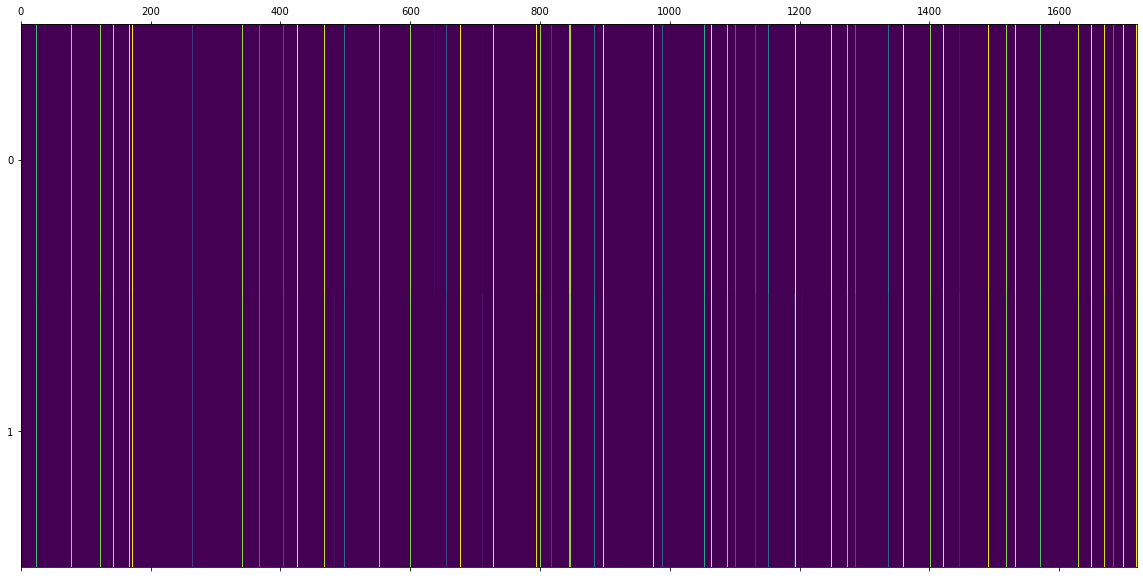

In [162]:
fig = plt.figure(figsize=(20, 10), facecolor="white")
ax = fig.add_subplot()
#ax.imshow(averaged_attention_matrix[:, :], cmap='hot', interpolation='nearest')
ax.matshow(averaged_attention_matrix[:2, :], aspect='auto', vmin=0)

In [86]:
averaged_attention_matrix.shape

(2, 1980)

## Obtaining the generative output score

In [17]:
len(dataloader)

386

### Figure out prevalence of very confident, correct vs incorrect answers

In [18]:
# only one context vector

exact_match_log_probabilities = []
incorrect_log_probabilities = []
exact_match_answers = []

for i, batch in tqdm(enumerate(dataloader)):
    
    (idx, _, _, context_ids, context_mask) = batch
    sequences = model.generate(
                input_ids=context_ids.cuda(),
                attention_mask=context_mask.cuda(),
                max_length=100,
                return_dict_in_generate=True,
                output_scores=True
            ).sequences

    
    for k, o in enumerate(sequences):
        ans = tokenizer.decode(o, skip_special_tokens=True)
        gold = eval_dataset.get_example(idx[k])['answers']
        score = ems(ans, gold)
        #print(score)
        # total += 1
        # exactmatch.append(score)
#         print("model generated output:")
#         print(ans)

#         print("")
#         print("ground truth:")
#         print(gold) 

    # print("extracting negative log probability ...")
    log_probability = model.obtain_log_generated_probability(
        input_ids=context_ids.cuda(),
        attention_mask=context_mask.cuda(),
        max_length=100

    )
    
    if score == True:
        exact_match_log_probabilities.append(log_probability.cpu().numpy())
        exact_match_answers.append(ans)
#         if len(exact_match_log_probabilities) >= 5:
#             print("exceeded five exact matches")
        
#         if len(exact_match_log_probabilities) >= 10:
#             print("exceeded ten exact matches")
    
    else:
        incorrect_log_probabilities.append(log_probability.cpu().numpy())


386it [17:32,  2.73s/it]


In [204]:
# load from local
exact_match_log_probabilities = np.load("../numpy_drops/exact_matches_dev.npy")
incorrect_log_probabilities = np.load("../numpy_drops/incorrects_dev.npy")
rouge_match_log_probabilities = np.load("../numpy_drops/rouge_matches_dev.npy")

In [205]:
with open("../numpy_drops/rouge_similarity_answers_dev", "rb") as f:
    rouge_matches = pickle.load(f)

len(rouge_matches)

152

In [206]:
len([el for el in rouge_matches if el[2] == 1.0])

58

In [207]:
zipped_rouge = list(zip(rouge_matches, rouge_match_log_probabilities))

In [208]:
filter_thresh = 0.8

filtered_matches = [el for el in zipped_rouge if (el[0][2] >= filter_thresh)]
print(len(filtered_matches))

filtered_match_log_probabilities = list(list(zip(*filtered_matches))[1])

filtered_match_log_probabilities[:5]

116


[0.10911045, 0.0055139223, 0.06866394, 0.122859955, 0.07732459]

In [209]:
print("rouge match distribution")
print(len(rouge_match_log_probabilities))
print(np.mean(rouge_match_log_probabilities))
print(np.std(rouge_match_log_probabilities))

rouge match distribution
152
0.064017996
0.062186707


In [210]:
print("exact match distribution")
print(len(exact_match_log_probabilities))
print(np.mean(exact_match_log_probabilities))
print(np.std(exact_match_log_probabilities))

exact match distribution
55
0.034867488
0.030445786


In [211]:
print("incorrect match distribution")
print(len(incorrect_log_probabilities))
print(np.mean(incorrect_log_probabilities))
print(np.std(incorrect_log_probabilities))

incorrect match distribution
234
0.16556306
0.11634628


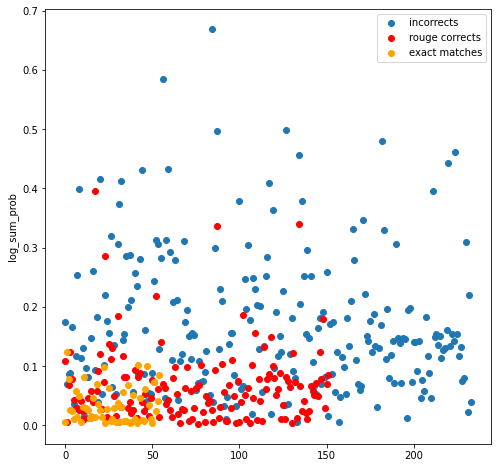

In [214]:
fig = plt.figure(figsize=(8,8), facecolor="white")
ax = fig.add_subplot(111)
ax.scatter(list(range(len(incorrect_log_probabilities))), incorrect_log_probabilities, label="incorrects")
ax.scatter(list(range(len(rouge_match_log_probabilities))), rouge_match_log_probabilities, color="red", label="rouge corrects")
ax.scatter(list(range(len(exact_match_log_probabilities))), exact_match_log_probabilities, color="orange", label="exact matches")
ax.set_ylabel("log_sum_prob")
ax.legend()

In [230]:
confidence_threshold = 0.03

true_positive = len([el for el in rouge_match_log_probabilities if el < confidence_threshold])
false_positive = len([el for el in incorrect_log_probabilities if el < confidence_threshold])

precision = true_positive / (true_positive + false_positive)
precision

0.8253968253968254

In [231]:
true_positive

52

In [232]:
false_positive

11

In [233]:
true_positive + false_positive

63

In [234]:
total_examples = len(rouge_match_log_probabilities) + len(incorrect_log_probabilities)

print(total_examples)

allowed_through = true_positive + false_positive

ratio_allowed_through = allowed_through / total_examples
ratio_allowed_through

386


0.16321243523316062

In [132]:
scorer = rouge_scorer.RougeScorer(['rougeL'], use_stemmer=True)
scores = scorer.score('The quick brown fox jumps over the lazy dog',
                      'The brown fox leaps over the lazy dog.')

scores2 = scorer.score('The fox dog really jumps',
                    'The fox dog jumps')

scores2

{'rougeL': Score(precision=1.0, recall=0.8, fmeasure=0.888888888888889)}

In [98]:
scores['rougeL'].precision

0.875

### inspect some generated sentences

In [143]:
for i, batch in enumerate(dataloader):
    (idx, labels, _, context_ids, context_mask) = batch
    for j in range(context_ids.shape[1]):

            print("====")
            print(j)
            context = tokenizer.decode(context_ids[0][j])
            print(context)
            if j >= 0:
                break
    
    if i > 0:
        break


====
0
question: When does the statute of limitations period begin for a plaintiff who experiences a continuing practice and policy of discrimination? title: context: Under this approach, if a plaintiff experienced a continuous policy or practice of discrimination, the continuing-violation doctrine delays the commencement of the statute-of-limitations period until the occurrence of the last discriminatory act in furtherance of that discriminatory practice.</s> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <

In [235]:
[el for el in rouge_matches if el[2] <= 0.8][:20]

[('Pennsylvania Rule of Civil Procedure 4009.21 provides that before a party can serve a subpoena on a non-party for the production of documents or things, the party must first give written notice to every other party of the intent to serve a subpoena and provide a copy of the proposed subpoena.',
  'Pennsylvania Rule of Civil Procedure 4009.21 requires that a party give written notice to every other party of the intent to serve a subpoena and provide a copy of the proposed subpoena.',
  0.7441860465116279),
 ('Because federal courts have limited jurisdiction, subject matter jurisdiction must be authorized by the Constitution and granted by statute. ',
  'Because federal courts have limited jurisdiction, they only have subject matter jurisdiction where authorized by the Constitution and statute.',
  0.7894736842105263),
 ('A negligent infliction of emotional distress claim brought by a bystander is called a Portee claim, which may be brought against product liability defendants along w

#### 

### Obtain example generated vs ground truth outputs

In [47]:
# only one context vector
for i, batch in enumerate(dataloader):
    
    if i == 7:
        print(f"training example: {i}")
        (idx, _, _, context_ids, context_mask) = batch
        sequences = model.generate(
                    input_ids=context_ids.cuda(),
                    attention_mask=context_mask.cuda(),
                    max_length=10,
                    return_dict_in_generate=True,
                    output_scores=True
                ).sequences

        print(sequences)
        for k, o in enumerate(sequences):
            ans = tokenizer.decode(o, skip_special_tokens=True)
            gold = eval_dataset.get_example(idx[k])['answers']
            score = ems(ans, gold)
            #print(score)
            # total += 1
            # exactmatch.append(score)
            print("model generated output:")
            print(ans)

            print("")
            print("ground truth:")
            print(gold) 
        
        print("extracting negative log probability ...")
        log_probability = model.obtain_log_generated_probability(
            input_ids=context_ids.cuda(),
            attention_mask=context_mask.cuda(),
            max_length=10
            
        )
        
        print(score)
        
        print(log_probability)
        
        break


training example: 7
tensor([[   0, 4407,    1]], device='cuda:0')
model generated output:
2002

ground truth:
['2002']
extracting negative log probability ...
True
tensor(0.6189, device='cuda:0')


In [92]:
softmax = torch.nn.Softmax(dim=1)
total_log_prob = 0
for i in range(len(outputs.scores)):
    print(torch.log(torch.max(softmax(outputs.scores[i]))))
    total_log_prob -= torch.log(torch.max(softmax(outputs.scores[i])))

total_log_prob

tensor(-0.9990, device='cuda:0')
tensor(-0.0031, device='cuda:0')
tensor(-2.1935e-05, device='cuda:0')
tensor(-7.8800e-05, device='cuda:0')
tensor(-0.0035, device='cuda:0')


tensor(1.0057, device='cuda:0')

## Comparing tokenizers

In [31]:
bert_tokenizer = transformers.AutoTokenizer.from_pretrained('bert-base-uncased')
t5_tokenizer = transformers.T5Tokenizer.from_pretrained('t5-base')

In [32]:
input_sequence = "Welcome to the HuggingFace Library"

In [35]:
bert_tokenized = bert_tokenizer(input_sequence, return_tensors='pt')
t5_tokenized = t5_tokenizer(input_sequence, return_tensors='pt')

print(bert_tokenized.input_ids)
print("===")
print(t5_tokenized.input_ids)

tensor([[  101,  6160,  2000,  1996, 17662, 12172,  3075,   102]])
===
tensor([[ 5242,    12,     8, 11560,  3896,   371,  3302,  5355,     1]])


In [40]:
print(bert_tokenizer.decode(bert_tokenized.input_ids[0]))
print("===")
print(t5_tokenizer.decode(t5_tokenized.input_ids[0]))

[CLS] welcome to the huggingface library [SEP]
===
Welcome to the HuggingFace Library</s>


In [46]:
bert_tokenizer.convert_ids_to_tokens(bert_tokenized.input_ids[0])

['[CLS]', 'welcome', 'to', 'the', 'hugging', '##face', 'library', '[SEP]']

In [45]:
t5_tokenizer.convert_ids_to_tokens(t5_tokenized.input_ids[0])

['▁Welcome', '▁to', '▁the', '▁Hug', 'ging', 'F', 'ace', '▁Library', '</s>']

In [52]:
z = torch.randn((2, 4))

In [54]:
msk = torch.tensor([[True, False, True], [False, True, False]])
msk2 = torch.tensor([[True, False, True, True]])

In [43]:
z

tensor([[-1.1771,  0.8998, -0.6725],
        [-1.0138,  1.7796, -0.3884]])

In [55]:
z.masked_fill(msk2 == 0, 0.0)

tensor([[ 1.3247,  0.0000, -0.0618, -0.7110],
        [-0.9271,  0.0000,  0.5299,  0.6540]])

In [242]:
from transformers import T5Tokenizer, T5ForConditionalGeneration
tokenizer = T5Tokenizer.from_pretrained('t5-small')


/opt/conda/envs/myenv/lib/python3.9/site-packages/transformers/models/t5/tokenization_t5.py:163: FutureWarning: This tokenizer was incorrectly instantiated with a model max length of 512 which will be corrected in Transformers v5.
For now, this behavior is kept to avoid breaking backwards compatibility when padding/encoding with `truncation is True`.
- Be aware that you SHOULD NOT rely on t5-small automatically truncating your input to 512 when padding/encoding.
- If you want to encode/pad to sequences longer than 512 you can either instantiate this tokenizer with `model_max_length` or pass `max_length` when encoding/padding.
- To avoid this warning, please instantiate this tokenizer with `model_max_length` set to your preferred value.
  warnings.warn(


In [243]:
model = T5ForConditionalGeneration.from_pretrained('t5-small')

In [244]:
input_ids = tokenizer.encode("summarize: Hello, my dog is cute", return_tensors="pt")  # Batch size 1

In [252]:
sequence = model.generate(input_ids, return_dict_in_generate=True, output_scores=True).sequences

In [259]:
sequence

tensor([[   0,   82, 1782,   19, 5295,   11, 5295,    5,    1]])

In [255]:
scores = model.generate(input_ids, return_dict_in_generate=True, output_scores=True).scores

In [262]:
torch.argmax(scores[1])

tensor(1782)

In [263]:
torch.max(scores[1])

tensor(-2.6708)